
## VoxNet model with and Complex Representation of ModelNet40 dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import print_function, division
# import os
import torch
# import pandas as pd
# from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader #, ConcatDataset
from torchvision import transforms, utils
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import rotate
import torch.nn as nn
import torch.backends.cudnn as cudnn
from sklearn import metrics
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
# import imp
import time
# import sys
import importlib
# import argparse
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### ModelNet dataset class

In [0]:
class ModelNetDataset(Dataset):
    """ModelNet10 dataset."""

    def __init__(self, X, Y, transform=None):
      """
      Args:
          data_file (string): Path to the npz file with annotations.
          transform (callable, optional): Optional transform to be applied
              on a sample.
      """

      self.transform = transform
      self.X = X
      self.Y = Y

      self.nsamples = len(self.X)

    def __len__(self):
      return self.nsamples

    def __getitem__(self, idx):
      x = self.X[idx]
      y = self.Y[idx]
      if self.transform:
          x, y = self.transform((x,y))
      return (x, y)

    def show_voxelgrid(self, sample):
      """Show 3D voxel"""
      X, Y = sample
      ax.voxels(X, edgecolor="k")
      # plt.pause(1)

### Class to apply Rotation transformation, given axis and angle

In [0]:
class Rotate(object):
  """Rotate the 3D voxel by specified degrees along given axis (X, Y or Z)

  Args:
  rotate_angle: Angle in degrees by which the 3D voxel is rotated (by default, 30 deg)
  rotate_axis: Axis of rotation (by default, along Z axis)
  multi_rotate: To apply multiple rotations on same object (by default: True)
  """

  def __init__(self, rotate_angle=30, rotate_axis=3, multi_rotate=True):
    self.rotate_angle = rotate_angle
    self.rotate_axis = rotate_axis
    self.multi_rotate = multi_rotate

  def __call__(self, sample):
    X, label = sample

    if self.rotate_axis == 1:
      ax_tup = (1, 2)
    elif self.rotate_axis == 2:
      ax_tup = (0, 2)
    elif self.rotate_axis == 3:
      ax_tup = (0, 1)
    else:
      raise ValueError('rotate axis should be 1, 2 or 3')

    rot_X = rotate(X, axes=ax_tup, angle=self.rotate_angle, cval=0.0, reshape=False)
    # Thresholding
    rot_X = (rot_X >= 0.5).astype(int)

    # Rotate voxel grid multiple times
    rotated_data = []
    if self.multi_rotate:
      n = 360 // self.rotate_angle
      # print('0')
      rotated_data.append(rot_X)
      for i in range(n-1):
        rot_X = rotate(rot_X, axes=ax_tup, angle=self.rotate_angle, cval=0.0, reshape=False)
         # Thresholding
        rot_X = (rot_X >= 0.5).astype(int)
        rotated_data.append(rot_X)
      rot_X = np.array(rotated_data)
      label = np.repeat(label, n).reshape(n, )

    return (rot_X, label)

In [0]:
import random
class RandomRotate(object):
  """Rotate the 3D voxel by specified degrees along given axis (X, Y or Z)

  Args:
  rotate_axis: Axis of rotation (by default, along Z axis)
  multi_rotate: To apply multiple rotations on same object (by default: True)
  """

  def __init__(self, rotate_axis=3):
    # self.rotate_angle = rotate_angle
    self.rotate_axis = rotate_axis
    # self.multi_rotate = multi_rotate

  def __call__(self, sample):
    X, label = sample

    if self.rotate_axis == 1:
      ax_tup = (1, 2)
    elif self.rotate_axis == 2:
      ax_tup = (0, 2)
    elif self.rotate_axis == 3:
      ax_tup = (0, 1)
    else:
      raise ValueError('rotate axis should be 1, 2 or 3')

    angle = random.randint(0, 360)

    rot_X = rotate(X, axes=ax_tup, angle=angle, cval=0.0, reshape=False)
    # Thresholding
    rot_X = (rot_X >= 0.5).astype(int)

    return (rot_X, label)

In [0]:
class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
    X, Y = sample
    if X.ndim == 3:
      X = torch.from_numpy(X).view(1, X.shape[0], X.shape[1], X.shape[2])
    else:
      X = torch.from_numpy(X).view(X.shape[0], 1, X.shape[1], X.shape[2], X.shape[3])
    if Y.ndim < 2:
      Y = torch.from_numpy(np.array(Y))
    else:
      Y = torch.from_numpy(Y).view(1, Y.shape[0])
    return (X, Y)

In [0]:
class toComplexRepr(object):
  def __init__(self):
    self.MAX_DISTANCE = float("inf")

  def normalize(self, X):
    if(np.min(X)<np.max(X)):
       X = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X
  
  def __call__(self, sample):
    X, label = sample
    dmap = mahotas.distance(1-X)    
    dmap = self.normalize(dmap)
    if np.isnan(dmap).any() == True:
      print('NAN detected..............')

    return (dmap, label)


In [0]:
""" ModelNet40 """

classes = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair','cone','cup', 'curtain','desk','door', 'dresser', 
           'flower_pot','glass_box', 'guitar', 'keyboard','lamp','laptop','mantel','monitor', 'night_stand', 'person','piano', 'plant', 'radio', 
           'range_hood', 'sink', 'sofa','stairs', 'stool','table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe','xbox']

data_file='drive/My Drive/Dataset/ModelNet40/New/X_train.npy'
label_file='drive/My Drive/Dataset/ModelNet40/New/y_train.npy'
test_data_file = 'drive/My Drive/Dataset/ModelNet40/New/X_test.npy'
test_label_file = 'drive/My Drive/Dataset/ModelNet40/New/y_test.npy'

data = np.load(data_file)
labels = np.load(label_file)

trainX, valX, trainY, valY = train_test_split(data, labels, test_size=0.3, random_state=42)
train_data = ModelNetDataset(trainX, trainY, transform=transforms.Compose([
                                              RandomRotate(rotate_axis=3),
                                               ToTensor()
                                           ]))
val_data = ModelNetDataset(valX, valY, transform=transforms.Compose([
                                               # RandomRotate(rotate_axis=3),
                                               ToTensor()
                                           ]))

test_data = ModelNetDataset(np.load(test_data_file), np.load(test_label_file), transform=transforms.Compose([
                                               # RandomRotate(rotate_axis=3),
                                               ToTensor()
                                           ]))

In [55]:
print('#Samples in train dataset: ', len(train_data))
print('#Samples in val dataset: ', len(val_data))
print('#Samples in test dataset: ', len(test_data))

dataset_sizes = {'train': len(train_data), 'val': len(val_data), 'test': len(test_data)}

#Samples in train dataset:  6882
#Samples in val dataset:  2950
#Samples in test dataset:  2468


### Functions for train and test model

In [0]:
"""### Functions for train and test model"""

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  train_losses = []
  val_losses = []
  train_acc = []
  val_acc = []

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # zero the parameter gradients
          optimizer.zero_grad()

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)
              
              inputs = inputs.reshape((-1, 1, 32, 32, 32))
              labels = labels.reshape(-1)
              # print(inputs.shape, labels.shape)
              inputs, labels = Variable(inputs), Variable(labels)
              # inputs, labels = shuffle(inputs, labels)

              

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs.float())
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels.long())

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

              del inputs, outputs, labels, preds
              torch.cuda.empty_cache()
          # if phase == 'train':
          #     scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))
          if phase == 'train':
            train_losses.append(epoch_loss)
            train_acc.append(epoch_acc)
          else:
            val_losses.append(epoch_loss)
            val_acc.append(epoch_acc)


          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)

  history = {'train_losses': train_losses, 'val_losses': val_losses, 'train_acc': train_acc, 'val_acc': val_acc}
  return model, history

def test_model(model, dataloaders, criterion):
    model.eval()
    test_loss = []
    test_acc = []
    running_loss = 0.0
    running_corrects = 0

    all_targets = np.empty(0)
    all_labels = np.empty(0)

        # Iterate over data.
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.reshape((-1, 1, 32, 32, 32))
        labels = labels.reshape(-1)
        # inputs, labels = shuffle(inputs, labels)
        inputs, labels = Variable(inputs), Variable(labels)

        # forward
        # track history if only in train
        with torch.no_grad():
          outputs = model(inputs.float())
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels.long())

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
          all_labels = np.append(all_labels, preds.detach().cpu().numpy())
          all_targets = np.append(all_targets, labels.detach().cpu().numpy())

    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'Test', epoch_loss, epoch_acc))
    
    test_loss.append(epoch_loss)
    test_acc.append(epoch_acc)

    print()
    print(metrics.classification_report(all_targets, all_labels, digits=3))

    history = {'test_loss': test_loss, 'test_acc': test_acc}
    return history

### VoxNet

In [0]:
class VoxNet(torch.nn.Module):   

    def __init__(self, num_classes=40, input_shape=(32,32,32)):

        super(VoxNet, self).__init__()
        self.input_shape = input_shape
        self.cnn_layers = torch.nn.Sequential(OrderedDict([
            ('conv1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            # ('bn1', torch.nn.BatchNorm3d(num_features=32)),
            ('relu1', torch.nn.LeakyReLU(0.1)),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            # ('bn2', torch.nn.BatchNorm3d(num_features=32)),
            ('relu2', torch.nn.LeakyReLU(0.1)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.4))
        ]))

        x = self.cnn_layers(torch.autograd.Variable(torch.rand((1, 1) + self.input_shape)))
        fc1_in = 1
        for n in x.size()[1:]:
            fc1_in *= n

        self.linear_layers = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(fc1_in, 128)),
            ('relu1', torch.nn.LeakyReLU(0.1)),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, num_classes))
        ]))

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)

        return x       

### Load and run simple VoxNet

### Load module

In [58]:
print(torch.cuda.is_available())

# load network
# print("loading module")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# module = importlib.import_module("models."+args.model)
# model = VoxNet().to(device)
model = VoxNet().to(device)
print(model)

True
VoxNet(
  (cnn_layers): Sequential(
    (conv1): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
    (relu1): LeakyReLU(negative_slope=0.1)
    (drop1): Dropout(p=0.2, inplace=False)
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (relu2): LeakyReLU(negative_slope=0.1)
    (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout(p=0.4, inplace=False)
  )
  (linear_layers): Sequential(
    (fc1): Linear(in_features=6912, out_features=128, bias=True)
    (relu1): LeakyReLU(negative_slope=0.1)
    (drop3): Dropout(p=0.4, inplace=False)
    (fc2): Linear(in_features=128, out_features=40, bias=True)
  )
)


In [0]:
data_loader = {'train': DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4),
               'val': DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)}
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

In [60]:
!pip install mahotas
import mahotas

# set optimization methods
criterion = nn.CrossEntropyLoss()
# print(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.01)

model, history = train_model(model, data_loader, criterion, optimizer, scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 3.2248 Acc: 0.1574
val Loss: 3.0445 Acc: 0.1929

Epoch 1/99
----------
train Loss: 2.8078 Acc: 0.2932
val Loss: 2.7671 Acc: 0.3722

Epoch 2/99
----------
train Loss: 2.4734 Acc: 0.3601
val Loss: 2.1464 Acc: 0.4197

Epoch 3/99
----------
train Loss: 2.1459 Acc: 0.4307
val Loss: 1.8659 Acc: 0.5186

Epoch 4/99
----------
train Loss: 1.9282 Acc: 0.4939
val Loss: 1.7871 Acc: 0.5397

Epoch 5/99
----------
train Loss: 1.8631 Acc: 0.4990
val Loss: 1.8492 Acc: 0.5092

Epoch 6/99
----------
train Loss: 1.8027 Acc: 0.5093
val Loss: 1.7345 Acc: 0.5366

Epoch 7/99
----------
train Loss: 1.6713 Acc: 0.5546
val Loss: 1.5063 Acc: 0.5956

Epoch 8/99
----------
train Loss: 1.5965 Acc: 0.5623
val Loss: 1.7311 Acc: 0.5515

Epoch 9/99
----------
train Loss: 1.5381 Acc: 0.5790
val Loss: 1.5348 Acc: 0.6034

Epoch 10/99
----------
train Loss: 1.5222 Acc: 0.5812
val Loss: 1.4403 Acc: 0.5986

Epoch 11/99
----------
train Loss: 1.4521 Acc: 0.5910
val Loss: 1.3725 Acc: 0.6261

Ep

### Evaluation/Results

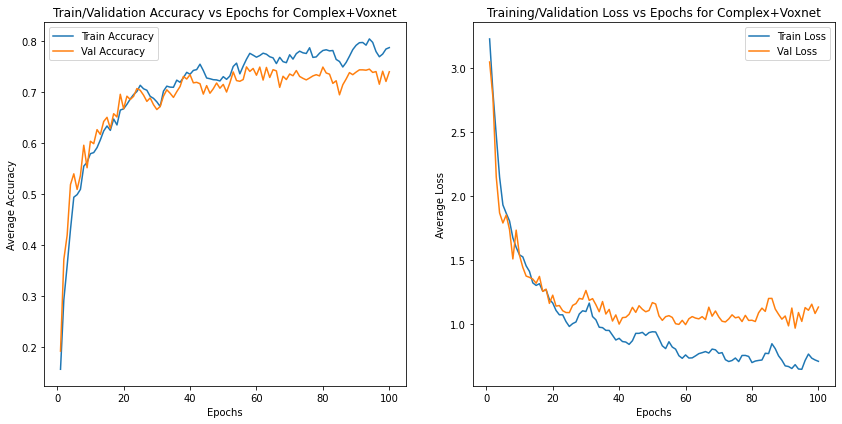

In [61]:
train_acc, train_loss = history['train_acc'], history['train_losses']
val_acc, val_loss = history['val_acc'], history['val_losses']

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Val Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Average Accuracy') 
plt.legend(loc='best')
plt.title('Train/Validation Accuracy vs Epochs for Complex+Voxnet') 
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1),train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1),val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.legend(loc='best')
plt.title('Training/Validation Loss vs Epochs for Complex+Voxnet')
plt.tight_layout()
plt.show()

In [62]:
test_model(model, test_loader, criterion)

Test Loss: 1.0837 Acc: 0.7119

              precision    recall  f1-score   support

         0.0      0.971     1.000     0.985       100
         1.0      0.667     0.440     0.530        50
         2.0      0.816     0.800     0.808       100
         3.0      0.171     0.350     0.230        20
         4.0      0.643     0.740     0.688       100
         5.0      0.847     0.940     0.891       100
         6.0      0.824     0.700     0.757        20
         7.0      0.835     0.960     0.893       100
         8.0      0.721     0.880     0.793       100
         9.0      0.917     0.550     0.687        20
        10.0      0.423     0.550     0.478        20
        11.0      0.147     0.700     0.243        20
        12.0      0.506     0.488     0.497        86
        13.0      0.583     0.700     0.636        20
        14.0      0.560     0.547     0.553        86
        15.0      0.312     0.250     0.278        20
        16.0      0.690     0.870     0.770       

{'test_acc': [tensor(0.7119, device='cuda:0', dtype=torch.float64)],
 'test_loss': [1.0836526767940924]}